In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

mpl.rcParams.update({'font.size': 8})
mpl.rcParams['figure.dpi'] = 300


In [132]:
start_time = 0
end_time = 10000

average_interevent_time = 10

class Distribution:
    def __init__(self, dist, params):
        self.dist = dist
        self.params = params

    def sample(self):
        # Draw a sample from the distribution. To enforce a temporal point process,
        # we need to draw a sample until we get a positive value.
        while True: 
            t = self.dist(*self.params)
            if t > 0:
                return t
    
    def sample_interval(self, t1, t2):
        t = [t1]
        while True:
            t.append(t[-1] + self.sample())
            if t[-1] > t2:
                break
        return t[1:-1]
    
class WeibullDistribution(Distribution):
    def __init__(self, mean, shape=1):
        self.mean = mean
        self.params = (mean / scipy.special.gamma(1 + 1/shape), shape)

    # override the sample method
    def sample(self):
        return np.random.weibull(self.params[1]) * self.params[0]
        
mean = 10

dist_normal = Distribution(np.random.normal, (mean, 1))
dist_exponential = Distribution(np.random.exponential, (mean,))
dist_lognormal = Distribution(np.random.lognormal, (np.log(mean) - 0.5,)) # lognormal takes as input the mean of the underlying nomal distribution 
dist_weibull = WeibullDistribution(mean, shape=0.8)

dist_list = [dist_normal, dist_exponential, dist_lognormal, dist_weibull]
name_list = ["Normal", "Exponential", "Lognormal", "Weibull"]

for dist, name in zip(dist_list, name_list):
    assert(np.abs(np.mean([dist.sample() for _ in range(100000)]) - mean) < 0.1)


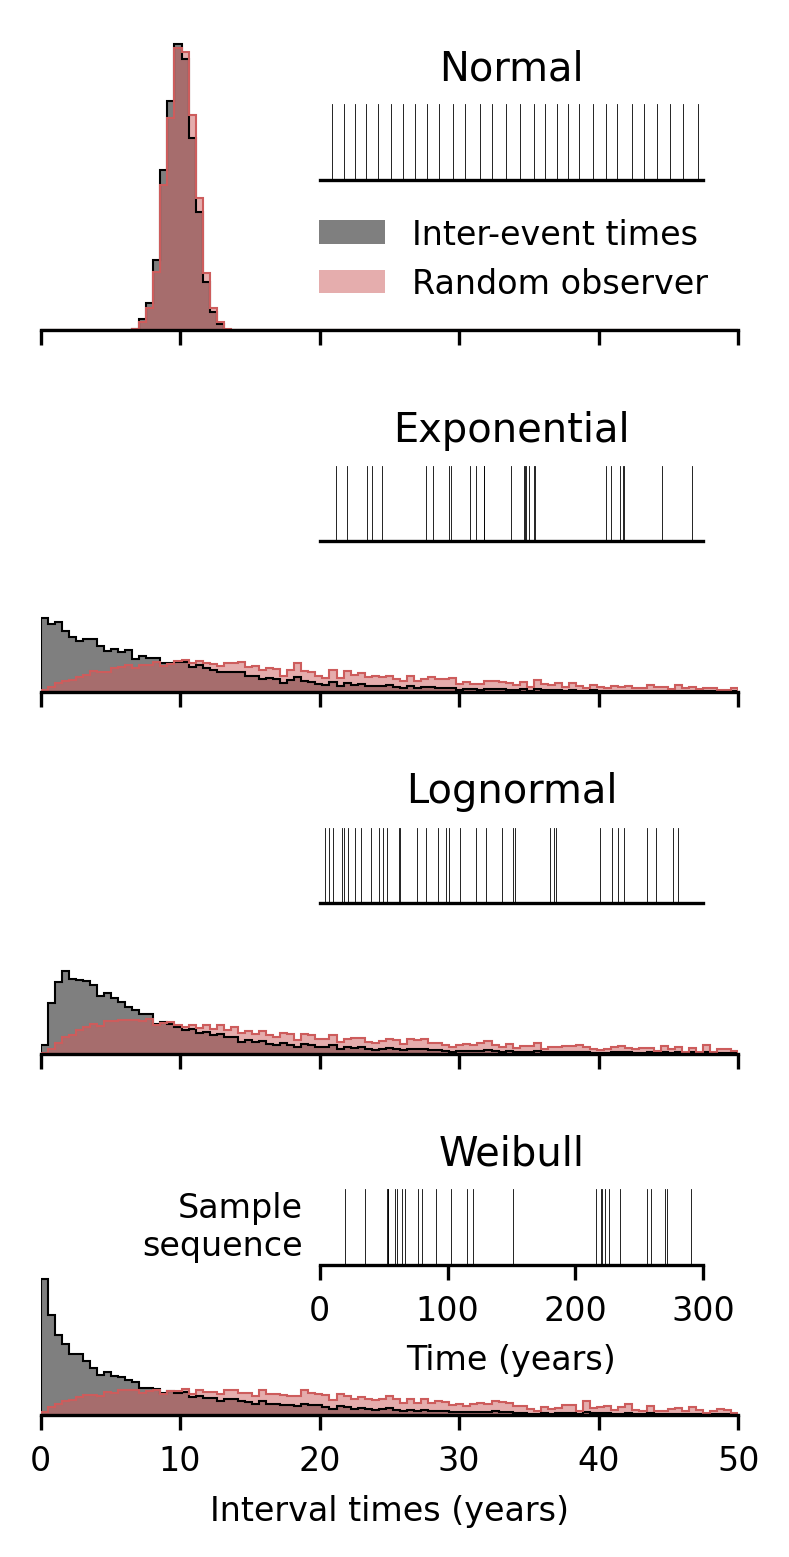

In [140]:
fig, ax = plt.subplots(len(dist_list), 1, sharex=True, sharey=True, figsize=(3, 6))

start_time = 0
end_time = 100000
num_samples = 100000

snip_time = 300


def get_lapse_time(tq, t):
    dt = t - tq
    negative_dt = np.abs(dt[dt < 0])
    return np.min(negative_dt) if np.any(negative_dt) else np.nan


def get_waiting_time(tq, t):
    dt = t - tq
    positive_dt = dt[dt > 0]
    return np.min(positive_dt) if np.any(positive_dt) else np.nan


bins = np.linspace(0, 5 * mean, 100)
hist_kwargs = {"bins": bins, "density": True}

for i, (dist, name) in enumerate(zip(dist_list, name_list)):

    t = np.array(dist.sample_interval(start_time, end_time))

    random_times = np.sort(
        np.random.uniform(start_time, end_time, size=num_samples)
    )

    interval_times = np.array(
        [
            get_waiting_time(tq, t) + get_lapse_time(tq, t) 
            for tq in random_times
        ]
    )

    ax[i].hist(np.diff(t), **hist_kwargs, color = 'k', alpha=0.5, label="Inter-event times")
    ax[i].hist(np.diff(t), **hist_kwargs, color = 'k', histtype='step', linewidth=0.5)
    ax[i].hist(interval_times, **hist_kwargs, color = 'indianred', alpha=0.5, label="Random observer")
    ax[i].hist(interval_times, **hist_kwargs, color = 'indianred', histtype='step', linewidth=0.5)
    
    # remove all top, left and right spines
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)    

    inset_ax = ax[i].inset_axes((0.4, 0.5, 0.55, 0.25))
    [inset_ax.axvline(t_i, color="k", lw=0.2) for t_i in t[t<snip_time]]
    inset_ax.set(
        xlim=(0, snip_time),
        yticks=[],
        xticks=[],
    )
    
    # remove all top, left and right spines
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['left'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)    

    
    inset_ax.set_title(name)

inset_ax.set(
    xlabel = "Time (years)",
    xticks = np.arange(0, snip_time+1, 100),
)

inset_ax.set_ylabel("Sample\nsequence", rotation=0, ha='right', va='center')



ax[0].legend(loc="lower right", frameon=False)

ax[-1].set(
    xlabel="Interval times (years)",
    xlim=(0, 5 * mean),
    yticks=[],
)



plt.savefig("waiting_time_paradox.png", dpi=300)



(array([ 1.,  2.,  2.,  1.,  6., 10., 24., 22., 19., 13.]),
 array([0.47605769, 0.5444443 , 0.61283092, 0.68121754, 0.74960416,
        0.81799078, 0.8863774 , 0.95476402, 1.02315064, 1.09153725,
        1.15992387]),
 <BarContainer object of 10 artists>)

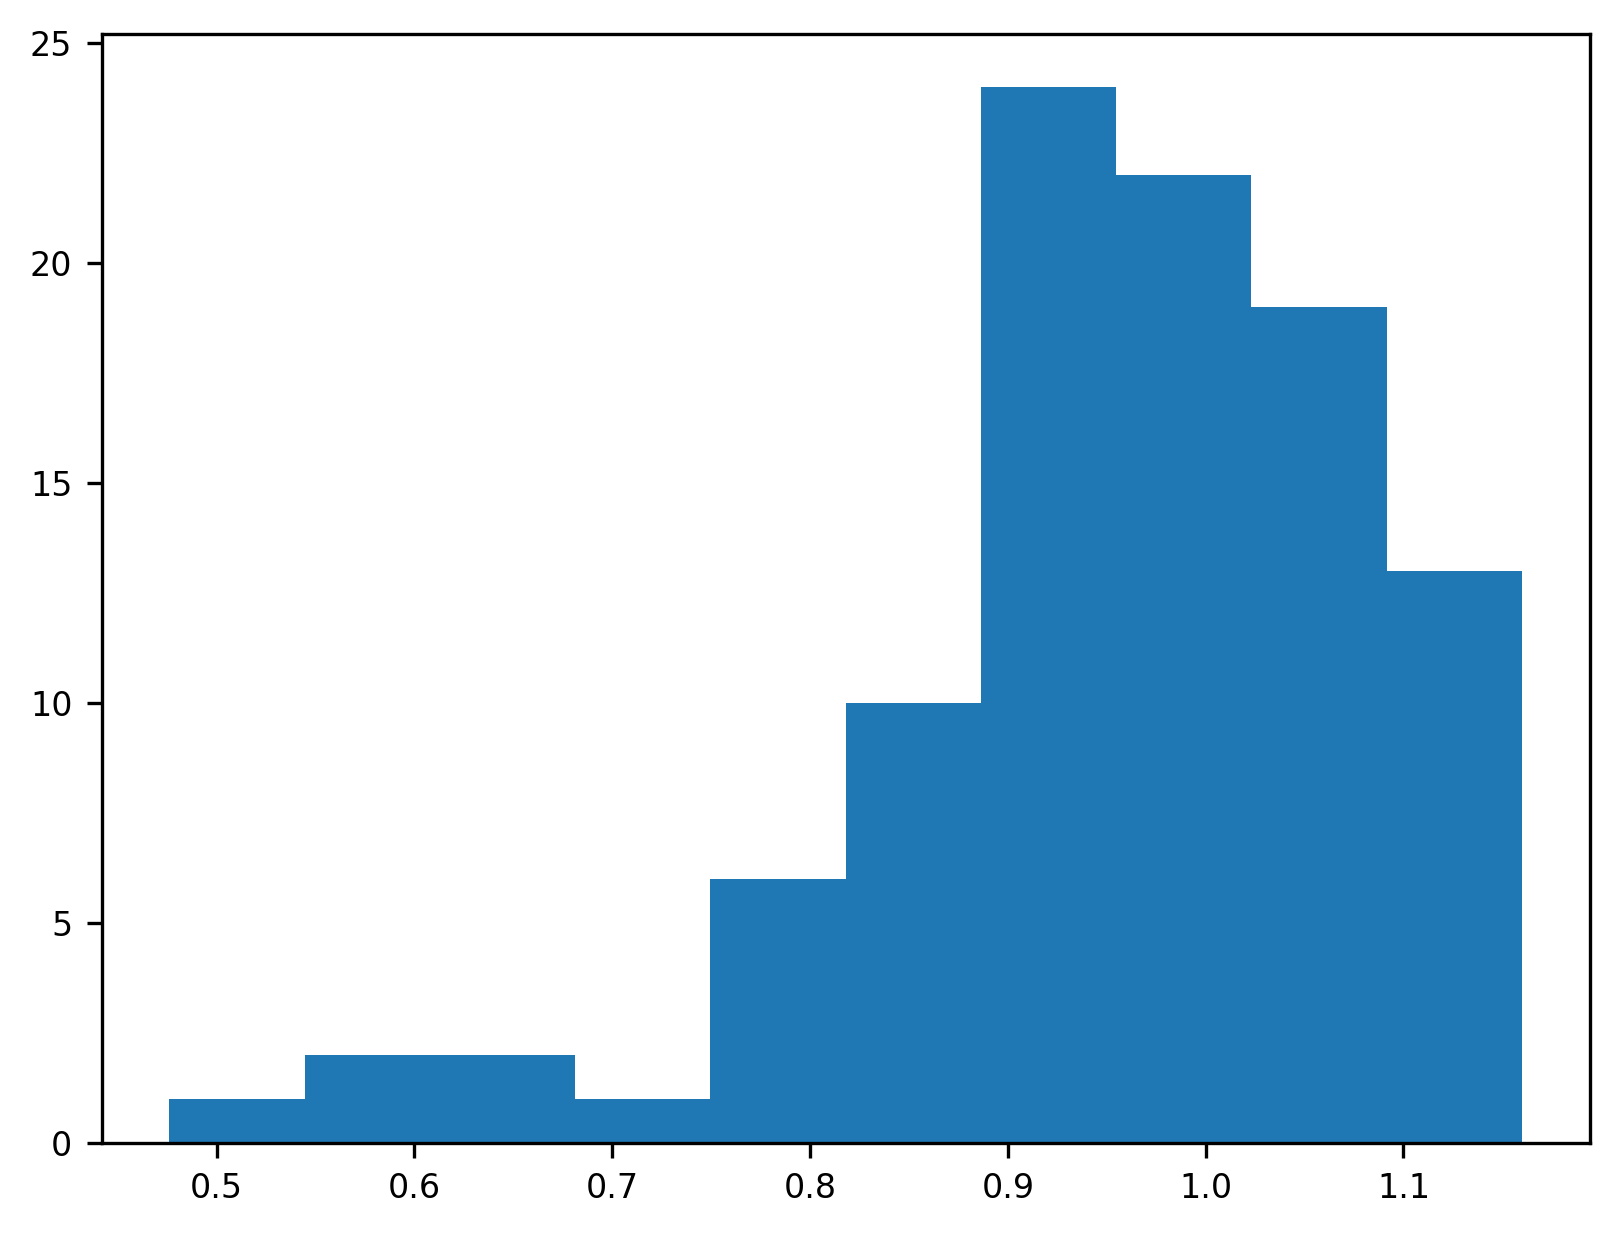

In [134]:
dist_weibull = Distribution(np.random.weibull, (mean,))
plt.hist([dist_weibull.sample() for _ in range(100)])
# dist_weibull.sample_interval(0, 1000)


In [135]:
dist